## Loading the environments 

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

## Importing the packages

In [2]:
from dotenv import load_dotenv
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

from langgraph.graph import StateGraph , START , END 
from langchain_core.messages import HumanMessage , AIMessage , SystemMessage
from typing import TypedDict
from langchain_core.runnables.graph import MermaidDrawMethod

In [3]:
model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

In [4]:
# from langchain_google_genai import ChatGoogleGenerativeAI
# model = ChatGoogleGenerativeAI(model="gemini-2.5-pro", temperature=0)

In [5]:
model.invoke("Hi, How are you?")

AIMessage(content="Hello! I'm doing great, thank you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 13, 'total_tokens': 29, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_c064fdde7c', 'id': 'chatcmpl-CPI9B94GI2DAOrBhiUFABXPkpmTaT', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--161e9eef-fde1-4389-b462-e1df026298b2-0', usage_metadata={'input_tokens': 13, 'output_tokens': 16, 'total_tokens': 29, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
result = model.invoke("Hi, How are you?")

In [7]:
result.content

"Hello! I'm doing great, thank you. How can I assist you today?"

## Some utility functions 

In [8]:
# to display the graph
def display_graph(app):
    # this function will display the graph of the app
    try:
        display(Image(app.get_graph().draw_mermaid_png()))
    except Exception as e:
        # This requires some extra dependencies and is optional
        print(e)


# To stream the output of the app
def stream_output(app, input):
    for output in app.stream(input):
        for key,value in output.items():
            print(f"here is output from {key}")
            print("_______")
            print(value)
            print("\n")



## Level 0 : Start with basic workflow

In [9]:
# define the state
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list,add_messages]


In [10]:
def greet_user(state:State):
    """
    This function will greet the user with a message
    """
    user_message = state["messages"][0].content
    return {"messages" : [f"Hello {user_message}!"]}

In [11]:
#define the graph
graph = StateGraph(State)

graph.add_node("User Greetings" , greet_user)

graph.add_edge(START, "User Greetings")
graph.add_edge("User Greetings", END)

# define the app
app = graph.compile()

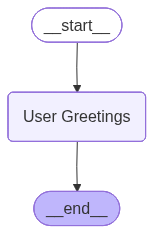

In [12]:
display_graph(app)

In [13]:
app.invoke({
    "messages" : "Suman"
})

{'messages': [HumanMessage(content='Suman', additional_kwargs={}, response_metadata={}, id='4bfb733f-1d63-4419-a55c-371789223b89'),
  HumanMessage(content='Hello Suman!', additional_kwargs={}, response_metadata={}, id='1999e6ff-db30-4d0f-bbec-0089052b4ee8')]}

In [14]:
stream_output(app, {
    "messages" : "Suman"})

here is output from User Greetings
_______
{'messages': ['Hello Suman!']}




## Level 1: 2 workflows in a graph

In [15]:
def greet_user(state: State):
    """
    This function will greet the user with a message
    """
    user_message = state["messages"][0].content
    
    return {"messages": [f"Hello {user_message}!"]}

def convert_to_uppercase(state: State):
    """
    This function will convert the input word to uppercase
    """
    last_message = state["messages"][-1].content
    return {"messages": [last_message.upper()]}


In [16]:
# Define the workflow
graph = StateGraph(State)

graph.add_node("User Greetings" , greet_user)
graph.add_node("Convert to Uppercase" , convert_to_uppercase)

graph.add_edge(START, "User Greetings")
graph.add_edge("User Greetings", "Convert to Uppercase")
graph.add_edge("Convert to Uppercase", END)

app = graph.compile()

In [17]:
display_graph(app)

Failed to reach https://mermaid.ink API while trying to render your graph. Status code: 400.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`


In [18]:
app.invoke({"messages" : "Suman"})

{'messages': [HumanMessage(content='Suman', additional_kwargs={}, response_metadata={}, id='80514d8e-387c-4907-ac6f-c814cbb9d08c'),
  HumanMessage(content='Hello Suman!', additional_kwargs={}, response_metadata={}, id='e1069a26-ff38-48a5-82ca-215fa2e0d7eb'),
  HumanMessage(content='HELLO SUMAN!', additional_kwargs={}, response_metadata={}, id='a0169e53-a398-40a9-9f55-d84613c48502')]}

In [19]:
stream_output(app, {"messages" : "Suman"})

here is output from User Greetings
_______
{'messages': ['Hello Suman!']}


here is output from Convert to Uppercase
_______
{'messages': ['HELLO SUMAN!']}




## Level 2: using an LLM and a function in the workflow

In [20]:
def get_response_from_llm(state: State):
    """
    This function will get the response from the LLM
    """
    user_input = state["messages"][0].content
    response = model.invoke(user_input)
    return {"messages": [response]}


def convert_to_uppercase(state:State):
    """
    This function will convert the message to uppercase
    """
    response_from_llm = state["messages"][-1].content
    uppercase_output = response_from_llm.upper()
    
    return {"messages": [uppercase_output]}

In [21]:
#define the workflow
graph = StateGraph(State)
graph.add_node("Get Response from LLM" , get_response_from_llm)
graph.add_node("Convert to Uppercase" , convert_to_uppercase)

graph.add_edge(START, "Get Response from LLM")
graph.add_edge("Get Response from LLM", "Convert to Uppercase")
graph.add_edge("Convert to Uppercase", END)

app = graph.compile()


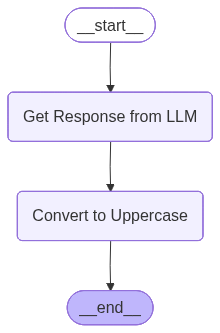

In [22]:
display_graph(app)

In [23]:
app.invoke({"messages" : "Who built the Taj mahal?"})

{'messages': [HumanMessage(content='Who built the Taj mahal?', additional_kwargs={}, response_metadata={}, id='c76de812-6571-456b-9d0e-ceaef3078eac'),
  AIMessage(content='The Taj Mahal was commissioned and built by the Mughal Emperor Shah Jahan. It was constructed in memory of his beloved wife Mumtaz Mahal, who died in 1631. The construction began in 1632 and was completed around 1653. The Taj Mahal is located in Agra, India, and is renowned for its stunning architecture and beauty.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 13, 'total_tokens': 86, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_c064fdde7c', 'id': 'chatcmpl-CPIEw5Yq6ml1ahS40rtvhn3ZEU9gl', 'service_tier': 'default', 'finish_re

In [24]:
stream_output(app, {"messages": "Who built the Taj mahal?"})

here is output from Get Response from LLM
_______
{'messages': [AIMessage(content='The Taj Mahal was commissioned and built by Mughal Emperor Shah Jahan. It was constructed in memory of his beloved wife Mumtaz Mahal. The construction began in 1632 and was completed around 1653. The Taj Mahal is located in Agra, India, and is renowned for its stunning architecture and beauty.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 13, 'total_tokens': 78, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_c064fdde7c', 'id': 'chatcmpl-CPIEzIiP4atBgX7oUwSHm2U03b4JJ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1e11dd89-eeb6-45c4-b90d-845ee77e93db-0', usage_metadata={'input_toke

## Level 3 : Real world use case 

In [25]:
def classify_sentiment(state:State):
    """
    This function will classify the sentiment of the message
    """
    user_input = state["messages"][0].content
    prompt = f"You are a sentiment classifier. You will be given a message and you will need to classify the sentiment of the message. The sentiment can be positive, negative or neutral. Return the sentiment as a string."
    final_message = user_input + prompt
    response = model.invoke(final_message)
    return {"messages": [response]}


def get_total_word_count(state):
    """
    This function will get the total word count of the message
    """
    user_input = state["messages"][0].content
    word_count = len(user_input.split())
    return {"messages": [f"Total word count: {word_count}"]}

In [26]:
# define the workflow
graph = StateGraph(State)
graph.add_node("Classify Sentiment" , classify_sentiment)
graph.add_node("Get Total Word Count" , get_total_word_count)

graph.add_edge(START, "Classify Sentiment")
graph.add_edge("Classify Sentiment", "Get Total Word Count")
graph.add_edge("Get Total Word Count", END)

app = graph.compile()

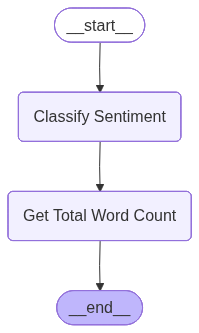

In [27]:
display_graph(app)

In [28]:
app.invoke({"messages": "I am happy with the quality of the product and the service"})

{'messages': [HumanMessage(content='I am happy with the quality of the product and the service', additional_kwargs={}, response_metadata={}, id='b7eed2b8-2b4b-45e5-be50-742e9bf820b0'),
  AIMessage(content='positive', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tokens': 60, 'total_tokens': 61, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_c064fdde7c', 'id': 'chatcmpl-CPIF7ZR1dD1a2rT4KyHbA8J7xj9RW', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--3a0eb1a5-cbec-4ccf-8904-3e0b12e46c1d-0', usage_metadata={'input_tokens': 60, 'output_tokens': 1, 'total_tokens': 61, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  Hum

In [29]:
stream_output(app, {"messages": "I am happy with the quality of the product and the service"})

here is output from Classify Sentiment
_______
{'messages': [AIMessage(content='positive', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tokens': 60, 'total_tokens': 61, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_c064fdde7c', 'id': 'chatcmpl-CPIF9ueJu42Fm1EyaPV2rqv57Zq6k', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e99804a6-4aac-4d9f-8a67-10e17828c48f-0', usage_metadata={'input_tokens': 60, 'output_tokens': 1, 'total_tokens': 61, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}


here is output from Get Total Word Count
_______
{'messages': ['Total word count: 12']}




## Prompts in langchain 

### 2.1 Simple Prompts in langchain - Static Messages

In [30]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

load_dotenv()

model = ChatOpenAI(model='gpt-4.1-mini', temperature=0)

result = model.invoke("Write a 5 line description on cricket")

print(result.content)

Cricket is a popular bat-and-ball sport played between two teams of eleven players each. The game is played on a circular or oval field with a rectangular 22-yard pitch at the center. Players score runs by hitting the ball and running between the wickets or by hitting boundaries. The team with the most runs at the end of the match wins. Cricket has various formats, including Test, One Day International (ODI), and Twenty20 (T20).


### 2.2 Prompt Template for dynamic messages

In [31]:
from langchain_core.prompts import PromptTemplate

# using prompt Template
template = PromptTemplate(
    template="Write a 5 line description on the {topic}",
    input_variables=['topic'],
    validate_template=True
)

# fill the values of the placeholders
prompt = template.invoke({'topic':'table tennis'})

result = model.invoke(prompt)

print(result.content)

Table tennis, also known as ping pong, is a fast-paced indoor sport played with small paddles and a lightweight ball. It involves two or four players hitting the ball back and forth across a net on a rectangular table. The objective is to score points by making the ball land on the opponent’s side without being returned. The game requires quick reflexes, agility, and precise hand-eye coordination. It is popular worldwide both as a recreational activity and a competitive sport.


### 2.3 Prompt Template for dynamic messages - Multiple input variables

In [32]:
from langchain_core.prompts import PromptTemplate

# Prompt template
template = PromptTemplate(

    template="""
    You are a detailed content creation agent.

    Your task is to write content about the topic: {topic_input}.
    User will give thier  preferred writing style {style_input} (e.g., formal, conversational, humorous, etc.) and the desired number of words {length_input} for the content.

    Please generate a detailed, engaging, and informative piece on the topic, matching the requested style and length as closely as possible.

    If you do not have enough information to write about the topic, respond with: "Insufficient information available" instead of guessing.
    """,

    input_variables=['topic_input', 'style_input', 'length_input'],
    validate_template=True
)

# template_structure  = template.invoke({'paper_input': 'The paper is about the theory of relativity', 
#                                        'style_input': 'Simple and intuitive', 
#                                        'length_input': '500 words'})

# print(str(template_structure))

chain = template | model

result = chain.invoke({
    'topic_input':'India s economic growth',
    'style_input':'Conversational',
    'length_input':'200 words'
})

print(result.content)


India’s economic growth has been a remarkable journey, marked by rapid transformation and resilience. Over the past few decades, India has evolved from a primarily agrarian economy to one of the world’s fastest-growing major economies. This growth story is driven by several factors, including a young and dynamic workforce, technological advancements, and significant reforms in various sectors.

One of the key drivers has been the IT and services sector, which has positioned India as a global hub for software development and business process outsourcing. Additionally, initiatives like “Make in India” aim to boost manufacturing and attract foreign investment, further diversifying the economy. The government’s focus on infrastructure development, digitalization, and financial inclusion has also played a crucial role in sustaining growth.

However, challenges remain, such as income inequality, unemployment, and the need for more robust healthcare and education systems. Despite these hurdle

## Basic chatbot and its limitations

In [33]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from dotenv import load_dotenv

load_dotenv()

model = ChatOpenAI(model='gpt-4.1-mini', temperature=0)

while True:
    user_input = input("You: ")
    if user_input.lower() == "exit":
        print("Exiting the chat...")
        break
    response = model.invoke(user_input)
    print("AI :" , response.content)

AI : Hello! How can I assist you today?
AI : The Taj Mahal was built by the Mughal Emperor Shah Jahan. It was constructed in memory of his beloved wife Mumtaz Mahal, who died in 1631. The construction of the Taj Mahal began in 1632 and was completed in 1653. The chief architect is believed to be Ustad Ahmad Lahori.
AI : Could you please specify who you are referring to? That way, I can provide the correct information about their birth date.
Exiting the chat...


## Adding chat history

In [34]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from dotenv import load_dotenv

load_dotenv()

chat_history = []

model = ChatOpenAI(model='gpt-4.1-mini', temperature=0)

while True:
    user_input = input("You: ")
    chat_history.append(user_input)
    if user_input.lower() == "exit":
        print("Exiting the chat...")
        break
    response = model.invoke(chat_history)
    chat_history.append(response.content)
    print("AI :" , response.content)

print("Chat History:")
print(chat_history)

AI : Hello! How can I assist you today?
AI : The Taj Mahal was built by the Mughal Emperor Shah Jahan. It was constructed in memory of his beloved wife Mumtaz Mahal, who passed away in 1631. The construction of the Taj Mahal began in 1632 and was completed in 1653. It is located in Agra, India, and is renowned for its stunning white marble architecture.
AI : Shah Jahan was born on January 5, 1592.
Exiting the chat...
Chat History:
['hi', 'Hello! How can I assist you today?', 'who built taj mahal', 'The Taj Mahal was built by the Mughal Emperor Shah Jahan. It was constructed in memory of his beloved wife Mumtaz Mahal, who passed away in 1631. The construction of the Taj Mahal began in 1632 and was completed in 1653. It is located in Agra, India, and is renowned for its stunning white marble architecture.', 'when was he born', 'Shah Jahan was born on January 5, 1592.', 'exit']


## Adding langchain's SystemMessage , HumanMessage , AIMessage

In [35]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

load_dotenv()

model = ChatOpenAI(model='gpt-4.1-mini', temperature=0)

messages=[
    SystemMessage(content='You are a helpful assistant'),
    HumanMessage(content='Tell me about TajMahal')
]

result = model.invoke(messages)

messages.append(AIMessage(content=result.content))

print(messages)

[SystemMessage(content='You are a helpful assistant', additional_kwargs={}, response_metadata={}), HumanMessage(content='Tell me about TajMahal', additional_kwargs={}, response_metadata={}), AIMessage(content='The Taj Mahal is a world-famous monument located in Agra, India. It is widely regarded as one of the most beautiful buildings ever created and is a UNESCO World Heritage Site. Here are some key details about the Taj Mahal:\n\n1. **History and Purpose**:  \n   The Taj Mahal was commissioned by Mughal Emperor Shah Jahan in 1632 in memory of his beloved wife Mumtaz Mahal, who died during childbirth. It serves as her mausoleum and symbolizes eternal love.\n\n2. **Architecture**:  \n   The Taj Mahal is an outstanding example of Mughal architecture, which combines elements from Islamic, Persian, Ottoman Turkish, and Indian architectural styles. It is primarily made of white marble and is renowned for its symmetrical design, intricate carvings, and beautiful inlay work with precious and

In [36]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from dotenv import load_dotenv

load_dotenv()

model = ChatOpenAI(model='gpt-4.1-mini', temperature=0)

chat_history = [
    SystemMessage(content='You are a helpful AI assistant')
]

while True:
    user_input = input('You: ')
    chat_history.append(HumanMessage(content=user_input))
    if user_input == 'exit':
        break
    result = model.invoke(chat_history)
    chat_history.append(AIMessage(content=result.content))
    print("AI: ",result.content)

print(chat_history)

AI:  Hello! How can I assist you today?
AI:  The Taj Mahal was built by the Mughal Emperor Shah Jahan. He commissioned the construction in memory of his beloved wife Mumtaz Mahal, who passed away in 1631. The construction began in 1632 and was completed in 1653. The Taj Mahal is located in Agra, India, and is renowned for its stunning architecture and beauty.
AI:  Emperor Shah Jahan was born on January 5, 1592. If you have any more questions about him or the Taj Mahal, feel free to ask!
[SystemMessage(content='You are a helpful AI assistant', additional_kwargs={}, response_metadata={}), HumanMessage(content='hi', additional_kwargs={}, response_metadata={}), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={}), HumanMessage(content='who built taj mahal', additional_kwargs={}, response_metadata={}), AIMessage(content='The Taj Mahal was built by the Mughal Emperor Shah Jahan. He commissioned the construction in memory of his beloved wife Mumt

## 3 ChatPromptTemplate - For dynamic message conversation

In [38]:
from langchain_core.prompts import ChatPromptTemplate

model = ChatOpenAI(model='gpt-4.1-mini', temperature=0)

chat_template = ChatPromptTemplate(
    [
        ("system", "You are a helpful {domain} expert"),
        ("human", "Explain about the {topic} in simple terms")
    ]
)

prompt = chat_template.invoke({"domain": "AI", "topic": "Machine Learning"})

print(prompt)


messages=[SystemMessage(content='You are a helpful AI expert', additional_kwargs={}, response_metadata={}), HumanMessage(content='Explain about the Machine Learning in simple terms', additional_kwargs={}, response_metadata={})]


## MessagePlaceHolder in ChatPromptTemplate

In [40]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

model = ChatOpenAI(model='gpt-4.1-mini', temperature=0)

#past chat history
chat_history = [
    HumanMessage(content="I want to request a refund for my order number 11564."),
    AIMessage(content="Your refund request for order number 11564 has been initiated. It will be processed in 3-5 business days. refund initiated on sept 3 2025")
    ]

# chat template
chat_template = ChatPromptTemplate([
    ('system','You are a helpful customer support agent'),
    MessagesPlaceholder(variable_name='chat_history'),
    ('human','{query}')
])

# create prompt
prompt = chat_template.invoke({'chat_history':chat_history, 'query':'Where is my refund . I have not received it yet.'})

result = model.invoke(prompt)

print(result.content)



I’m sorry to hear that you haven’t received your refund yet. Refunds typically take 3-5 business days to process after initiation. Since your refund was initiated on September 3, 2025, it should be completed soon. 

Could you please confirm the payment method you used for the order? This will help me assist you further in tracking the refund.


## 4. Routers in langgraph

In [41]:
from typing_extensions import TypedDict

class State(TypedDict):
    current_state: str

In [42]:
def node_1(state):
    print("Now in Node 1")
    return {"current_state": state["current_state"] + " Hey I am in Node 1"}

def node_2(state):
    print("Now in Node 2")
    return {"current_state": state["current_state"] + " Hey I am in Node 2"}

def node_3(state):
    print("Now in Node 3")
    return {"current_state": state["current_state"] + " Hey I am in Node 3"}

In [43]:
import random
from typing import Literal

def get_random_node(state:State):
    """
    This function will return a random node
    """
    
    current_node = state["current_state"]

    if random.random() < 0.5:
        return "Node_2"
    else:
        return "Node_3"


In [44]:
#define the workflow
graph = StateGraph(State)
graph.add_node("Node 1" , node_1)
graph.add_node("Node 2" , node_2)
graph.add_node("Node 3" , node_3)

graph.add_edge(START, "Node 1")
graph.add_conditional_edges(
    "Node 1",
    get_random_node,
    {
        "Node_2": "Node 2",
        "Node_3": "Node 3"
    }
)
graph.add_edge("Node 2", END)
graph.add_edge("Node 3", END)

app = graph.compile()

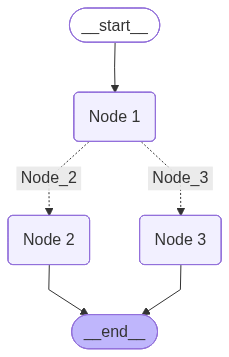

In [45]:
display_graph(app)

In [46]:
app.invoke({"current_state": "Start"})

Now in Node 1
Now in Node 2


{'current_state': 'Start Hey I am in Node 1 Hey I am in Node 2'}

## 4.1 Routers real life use case

In [47]:
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [52]:

#defining the nodes 

def get_user_intent(state:State):
    """
    This function will get the user intent from the user input
    
    """

    user_input = state["messages"][0].content

    # Prompt template
    template = PromptTemplate(

        template="""You are a classifier. Classify the user query as either "complaint" or "query".

        Return ONLY one word: either "complaint" or "query", nothing else.

        User Query: {user_input}

        Classification:""",

        input_variables=['user_input'],
        validate_template=True
        )

    chain = template | model


    result = chain.invoke({
        "user_input": user_input
    })

    return {"messages": [result]}


def route_user_query(state:State):
    """
    This function will route the user query to the appropriate node
    """
    intent = state["messages"][-1].content.strip().lower()
    if "complaint" in intent:
        return "Route_Complaint"
    else:
        return "Route_Query"


def handle_complaint(state:State):
    """
    This function will handle the complaint
    """

    user_input = state["messages"][0].content
    
    complaint_template = PromptTemplate(
        template = """
        You are a helpful assistant , you will be given a user complaint and you will need to handle the complaint.
        User Complaint : {user_input}
        """,
        input_variables = ["user_input"],
        validate_template = True
    )

    chain = complaint_template | model

    result = chain.invoke({
        "user_input": user_input
    })

    return {"messages": [result]}

def handle_query(state:State):
    """
    This function will handle the query
    """

    user_input = state["messages"][0].content
    
    query_template = PromptTemplate(
        template = """
        You are a helpful assistant , you will be given a user query and you will need to handle the query.
        User Query : {user_input}
        """,
        input_variables = ["user_input"],
        validate_template = True
    )

    chain = query_template | model

    result = chain.invoke({
        "user_input": user_input
    })

    return {"messages": [result]}


In [53]:
graph = StateGraph(State)

graph.add_node("Get User Intent", get_user_intent)
graph.add_node("Complaint", handle_complaint)
graph.add_node("Query", handle_query)

graph.add_edge(START, "Get User Intent")
graph.add_conditional_edges(
    "Get User Intent",
    route_user_query,
    {
        "Route_Complaint": "Complaint",
        "Route_Query": "Query"
    }
)
graph.add_edge("Complaint", END)
graph.add_edge("Query", END)

app = graph.compile()

In [54]:
display_graph(app)

Failed to reach https://mermaid.ink API while trying to render your graph. Status code: 400.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`


In [55]:
response = app.invoke({"messages": "I am not at all happy with the sofa that I purchased from Costco last week"})
print(response["messages"][-1].content)


I'm sorry to hear that you're not happy with the sofa you purchased from Costco. Could you please provide more details about the issue you're experiencing? This will help me assist you better. For example, is there a problem with the quality, comfort, delivery, or something else? Additionally, if you have your order number or receipt handy, that would be helpful. We're here to help resolve this for you.
